# Credit Based Movie Recommender
DataSet:
 - This dataset is from [Open Movie Database](http://www.omdbapi.com/)
 - It was downloaded from their website using the APIs provided
 - We have roughly 65K movies and their attributes such as rating, vote count and actors etc.
 
Objective:
 - Build a credit based movie recommender that recommends movies based on a similarity of Genre, Directors and Actors 
 - User inputs a movie name and similar movies based on similarity score are recommended

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import io

In [2]:
temp = pd.read_json('movies.json')

In [3]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 0 to 62422
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         62416 non-null  object
 1   Year          62418 non-null  object
 2   Rated         62418 non-null  object
 3   Released      62418 non-null  object
 4   Runtime       62418 non-null  object
 5   Genre         62418 non-null  object
 6   Director      62418 non-null  object
 7   Writer        62418 non-null  object
 8   Actors        62418 non-null  object
 9   Plot          62418 non-null  object
 10  Language      62418 non-null  object
 11  Country       62418 non-null  object
 12  Awards        62418 non-null  object
 13  Poster        62418 non-null  object
 14  Ratings       62418 non-null  object
 15  Metascore     62418 non-null  object
 16  imdbRating    62418 non-null  object
 17  imdbVotes     62418 non-null  object
 18  imdbID        62418 non-null  object
 19  Type

We will be using Title, Genre, Director and Actors for our recommender system. Poster is needed to present the result in a nice format

In [4]:
movies = temp[['Title', 'Genre', 'Director', 'Actors', 'Poster']]

Lets check if we have any Nan's

In [5]:
movies.isnull().sum(axis=0)

Title       7
Genre       5
Director    5
Actors      5
Poster      5
dtype: int64

In [6]:
movies[movies.Title.isnull()==True]

,Title,Genre,Director,Actors,Poster
971,None,"Biography, Drama",Matthew Broderick,"Matthew Broderick, Jeffrey Force, Peter Rieger...",https://m.media-amazon.com/images/M/MV5BYzYxZj...
50104,None,None,None,None,None
50105,None,None,None,None,None
57381,None,None,None,None,None
59805,None,None,None,None,None
59996,None,None,None,None,None
60435,None,Drama,Marlen Khutsiev,"Vladislav Pilnikov, Aleksei Zelenov, Marina Kh...",N/A


Let's get rid of these

In [7]:
indices_to_drop = movies[movies.Title.isnull()==True].index
movies = movies.drop(axis='index', index=indices_to_drop)
movies.reset_index(inplace=True)
movies.isnull().sum(axis=0)

index       0
Title       0
Genre       0
Director    0
Actors      0
Poster      0
dtype: int64

All good!

In [8]:
movies.head()

,index,Title,Genre,Director,Actors,Poster
0,0,Toy Story,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,1,Jumanji,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,2,Grumpier Old Men,"Comedy, Romance",Howard Deutch,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,3,Waiting to Exhale,"Comedy, Drama, Romance",Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,4,Father of the Bride Part II,"Comedy, Family, Romance",Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",https://m.media-amazon.com/images/M/MV5BOTEyNz...


We need to remove spaces from Directors's and Actors' name. So Tom Hanks should be updated to a single word tomhanks. We don't want our countvectorizer to treat Tom and Hanks as two separate words.We are going to use just first 3 directors/actors for the movies. We are assuming that they are listed in order of importance

In [9]:
def clean_data(x):    
    x_list = x.split(',')
    x = [x.lower().replace(' ','') for x in x_list]
    if len(x) > 2:
        return x[0:2]
    else:
        return x

def clean_genre(x):
    return x.lower().split(',')
    
movies.loc[:,'Actors']   = movies.Actors.apply(clean_data).values
movies.loc[:,'Director'] = movies.Director.apply(clean_data).values
movies.loc[:,'Genre']    = movies.Genre.apply(clean_genre).values

In [10]:
movies.head()

,index,Title,Genre,Director,Actors,Poster
0,0,Toy Story,"[animation, adventure, comedy, family, fan...",[johnlasseter],"[tomhanks, timallen]",https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,1,Jumanji,"[adventure, comedy, family, fantasy]",[joejohnston],"[robinwilliams, jonathanhyde]",https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,2,Grumpier Old Men,"[comedy, romance]",[howarddeutch],"[waltermatthau, jacklemmon]",https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,3,Waiting to Exhale,"[comedy, drama, romance]",[forestwhitaker],"[whitneyhouston, angelabassett]",https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,4,Father of the Bride Part II,"[comedy, family, romance]",[charlesshyer],"[stevemartin, dianekeaton]",https://m.media-amazon.com/images/M/MV5BOTEyNz...


In [11]:
def create_soup(x):
    return  ' '.join(x['Genre']) + ' ' +' '.join(x['Director']) + ' ' + ' '.join(x['Actors'])

In [12]:
movies.loc[:,'soup'] = movies.apply(create_soup, axis=1).values

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])
count_matrix.shape

(62416, 76824)

In [14]:
# Memory usage is too high when including plot and my computer cannot calculate cosine similarities when features are stacked horizontally totalling up to 200K features
# from scipy import sparse
# feature_matrix = sparse.hstack([tfidf_matrix, count_matrix])
# feature_matrix.shape
# I can probably calculate by writing to disk but that something I will do later

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

#Calculate count(Genre, Director, Actor) cosine similarity
count_cosine_sim = cosine_similarity(count_matrix)

In [22]:
def get_recommended_movies(title, cosine_sim = count_cosine_sim):
    idx = movies[movies.Title==title].index  
    if len(idx)==0:
        print('Matching movie not found')         
    else:        
        scores = list(cosine_sim[idx][0])
        scores = list(enumerate(scores))  
        scores = sorted(scores, key = lambda x:x[1], reverse=True)   
        scores = scores[1:11]
        movie_idx = [i[0] for i in scores]    
        return movie_idx

In [25]:
def display_recommended_movies(movie_idx):    
    try:
        plt.figure(figsize = (20, 10))
        gs = gridspec.GridSpec(2, 5)
        gs.update(wspace=0.01, hspace=0.18)
        for i, j in enumerate(movie_idx):     
            try:
                image = io.imread(movies.iloc[j]['Poster'])
            except:
                image = io.imread('posters/image_not_found.png')
            ax = plt.subplot(gs[i])
            ax.imshow(image)
            ax.set_ylabel(movies.iloc[j]['Title'])         
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    except:
        pass

Enter a movie that you like? Toy Story


You entered: Toy Story


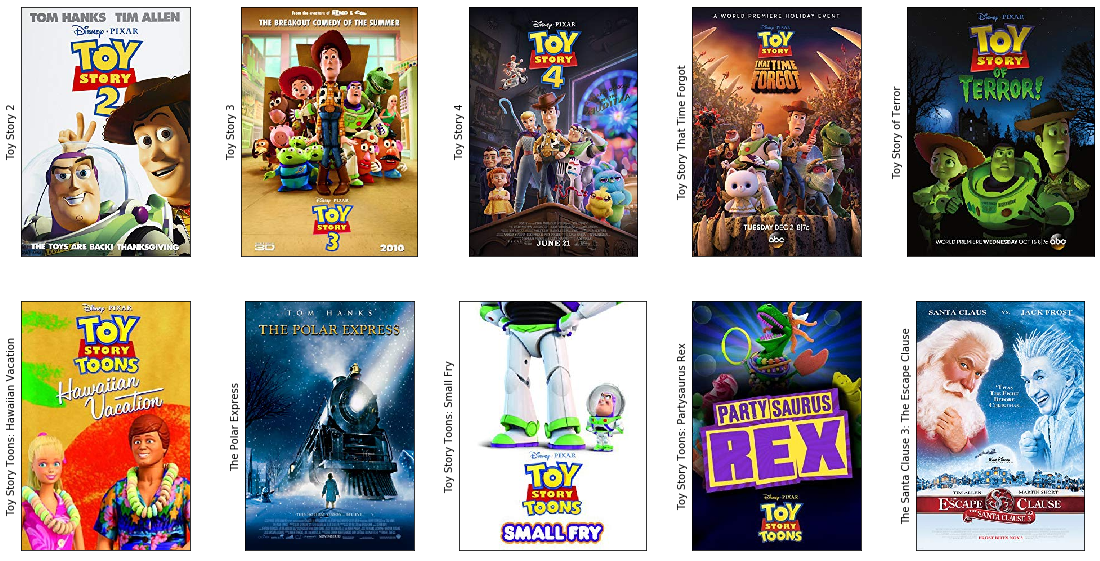

In [46]:
val = input("Enter a movie that you like?")
print('You entered: ' + val)
display_recommended_movies(get_recommended_movies(val))